In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

### Import package

In [39]:
import sys
import os
sys.path.append('../')
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Data cleaning").getOrCreate()
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from yaml import load as yaml_load
import pyspark.sql.functions as func
from sklearn.metrics import confusion_matrix
import numpy as np

### Import classes from src

In [5]:
from src.data.make_dataset import LoadDataframe
from src.features.build_features import extract_features_classification
from src.models.train_model import model_classification

### Functions to load yaml file configuration

In [6]:
def _load_config_file(config_file):
    """
    Load configuration file
    :param config_file: is the configuration file
    :return: configuration
    :rtype: dict
    """
    with open(config_file) as yml_config:
        return yaml_load(yml_config)

def _build_configuration(config_file):
    """
    Build the operation configuration dict
    :param config_file: is the path to the yaml config_file
    :type: string
    :return: config: global configuration
    :rtype dict
    """
    # yaml config
    config = _load_config_file(config_file)
    return config


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.figure(figsize=(15, 15))

### Loads yaml file configuration

In [8]:
config_file = "/home/ml/Documents/Crime_Chigaco_Spark/config/config.yml"
config = _build_configuration(config_file)

### Loads  LoadDataframe class, for more informations you can use help(LoadDataframe)

In [9]:
%%time
obj_df_loaded = LoadDataframe(config, '2013', '2014')

CPU times: user 728 µs, sys: 82 µs, total: 810 µs
Wall time: 7.75 ms


### loads temperature data, 
### socio-economic data, 
### weather description.
### remarks: weather description and temperature datas are valid from 2012

In [10]:
df_crimes_socio = obj_df_loaded.df_crime_socio()
df_temp = obj_df_loaded.df_temperature()
df_sky  = obj_df_loaded.df_sky()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


### Loads extract_features_classification

In [11]:
obj_extract_features_classification = extract_features_classification(config, df_crimes_socio, df_temp, df_sky)

In [12]:
df_ml = obj_extract_features_classification.extract_feature()

### Loads model_classification

In [13]:
obj_model_classification = model_classification(config, df_ml)

### Show some data from df_ml (dataframe for machine learning, features extraction)

In [14]:
df_ml.limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
year,2013,2013,2013,2013,2013,2013,2013,2013,2013,2013
month,11,12,6,2,2,3,5,4,5,6
day,7,2,10,7,19,13,1,24,13,25
hour,8,4,10,15,15,20,4,10,6,14
community_area_number,43,58,44,54,54,54,23,69,71,54
id,10754746,9412469,9166760,9001193,9015161,9045921,9110189,9120287,9127714,9189660
cas_number,HZ517281,HW555076,HW312239,HW147978,HW162837,HW191139,HW255069,HW246460,HW271951,HW334628
date,2013-11-07 08:00:00,2013-12-02 04:28:00,2013-06-10 10:20:00,2013-02-07 15:45:00,2013-02-19 15:45:00,2013-03-13 20:35:00,2013-05-01 04:10:00,2013-04-24 10:55:00,2013-05-13 06:40:00,2013-06-25 14:00:00
block,019XX E 75TH ST,028XX W 48TH PL,080XX S COTTAGE GROVE AVE,130XX S LANGLEY AVE,130XX S LANGLEY AVE,130XX S LANGLEY AVE,010XX N PULASKI RD,065XX S CHICAGO SKYWAY EXPY OB,017XX W 80TH ST,130XX S LANGLEY AVE
iucr,0890,0560,0486,0460,0460,2027,0460,1812,0820,0460


### Training model, in this case we use random forest classifier on 2013 data

In [15]:
%%time
rf_model = obj_model_classification.train_RF()

CPU times: user 4.66 s, sys: 771 ms, total: 5.43 s
Wall time: 1h 3min 38s


### the model will be tested on 2014 data

In [16]:
%%time
obj_df_loaded_2014 = LoadDataframe(config, '2014', '2015')

CPU times: user 251 µs, sys: 0 ns, total: 251 µs
Wall time: 255 µs


### Loads data for testing

In [17]:
df_crimes_socio_2014 = obj_df_loaded_2014.df_crime_socio()
df_temp_2014 = obj_df_loaded_2014.df_temperature()
df_sky_2014  = obj_df_loaded_2014.df_sky()

/usr/lib/spark/spark-2.4.0-bin-hadoop2.7/python/pyspark/sql/dataframe.py:1793: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


### Extract features for 2014 data

In [18]:
obj_extract_features_classification_2014 = extract_features_classification(config, df_crimes_socio_2014,\
                                                                           df_temp_2014, df_sky_2014)

In [19]:
df_ml_test = obj_extract_features_classification_2014.extract_feature()

### Prediction

In [20]:
df_prediction_test = rf_model.transform(df_ml_test)

### Show some results

In [21]:
df_prediction_test.select('primary_type','label', 'prediction','predictedLabel').limit(1000).toPandas().sample(10)

,primary_type,label,prediction,predictedLabel
898,NARCOTICS,2.0,2.0,NARCOTICS
300,NARCOTICS,2.0,0.0,THEFT_ROBBERY_BURGLARY
610,ASSAULT_BATTERY,1.0,0.0,THEFT_ROBBERY_BURGLARY
976,ASSAULT_BATTERY,1.0,0.0,THEFT_ROBBERY_BURGLARY
411,THEFT_ROBBERY_BURGLARY,0.0,0.0,THEFT_ROBBERY_BURGLARY
897,ASSAULT_BATTERY,1.0,2.0,NARCOTICS
317,THEFT_ROBBERY_BURGLARY,0.0,0.0,THEFT_ROBBERY_BURGLARY
170,THEFT_ROBBERY_BURGLARY,0.0,0.0,THEFT_ROBBERY_BURGLARY
621,THEFT_ROBBERY_BURGLARY,0.0,1.0,ASSAULT_BATTERY
494,THEFT_ROBBERY_BURGLARY,0.0,0.0,THEFT_ROBBERY_BURGLARY


### Evaluation of model

In [22]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [25]:
predictions = df_prediction_test.select(func.col("label"), func.col("prediction")).cache()

In [26]:
accuracy = evaluator.evaluate(predictions)

## Score 

In [33]:
y_test = df_prediction_test.select('primary_type').toPandas()['primary_type']

In [37]:
y_pred = df_prediction_test.select('predictedLabel').toPandas()['predictedLabel']

In [27]:
print(accuracy)

0.6596111642408194


### Confusion matrix

Confusion matrix, without normalization
[[29646  4689 31973]
 [ 1240 11549 16115]
 [ 3026  4533 78128]]
Normalized confusion matrix
[[0.45 0.07 0.48]
 [0.04 0.4  0.56]
 [0.04 0.05 0.91]]


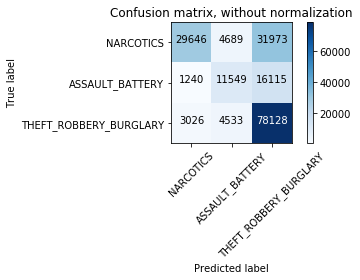

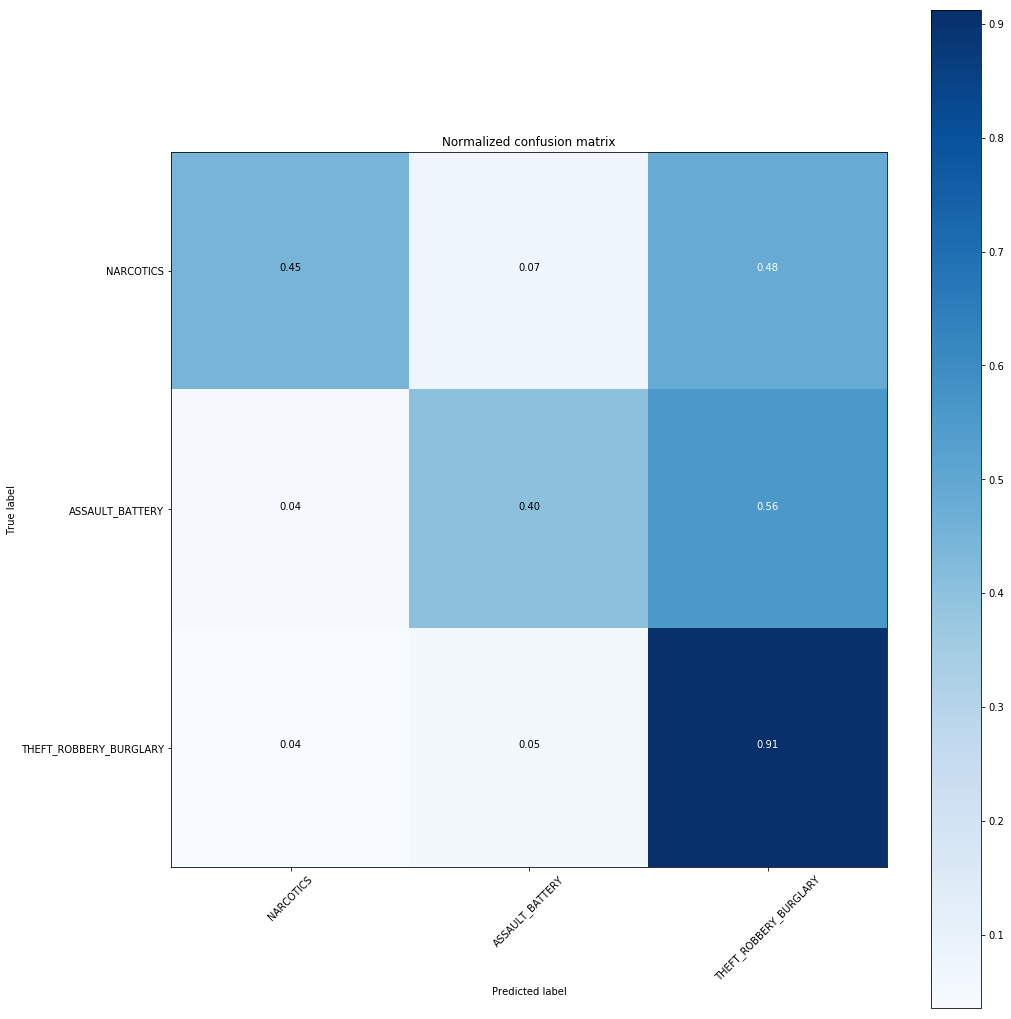

<Figure size 1080x1080 with 0 Axes>

In [45]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_pred) 
np.set_printoptions(precision=2)
class_names = ['NARCOTICS','ASSAULT_BATTERY', 'THEFT_ROBBERY_BURGLARY']
# Plot non-normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figsize = (10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')